# MintPy Processing

This notebook performs the MintPy timeseries processing. If you you're processing an ascending and descending track you'll need to run this workflow twice. Once for each track. I've had to add some strange working directory management to get this workflow to run on my local machine (run the load_data step in the directory the hyp3 data is located in, then copy it into a processing directory) but feel free to change this workflow if your machine is different.

## setup

In [1]:
%matplotlib inline
import glob
import sys
import shutil
import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

from mintpy.objects import timeseries
from datetime import datetime
import numpy as np
from skimage.morphology import remove_small_objects

from scipy.stats import linregress
import pandas as pd
import matplotlib
import datetime

['load_data', 'modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error']
  ['invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography']
  ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']

In [2]:
cd /home/micromamba/data

/home/micromamba/data


In [3]:
cp /home/micromamba/scripts/configs/asc_lower.cfg ./hyp3.cfg

## load_data

In [ ]:
!load_data.py -t hyp3.cfg

## double_difference

This the only step that isn't included in the normal MintPy `smallbaselineApp` workflow. It highlights local deformation, but obscures the presence of large-scale (greater than 10 km scale) deformation and unwrapping errors. See [Bekaert et. al 2020](https://www.sciencedirect.com/science/article/pii/S0034425720303539) for more details.

In [ ]:
desired_width = 2000
pixel_size = 40

x = 750
n_pixels = np.floor((desired_width / 40) /2)
width = ((n_pixels*2)+1)*400
print(f'N pixels: {n_pixels}\nActual width: {width}')

In [ ]:
from skimage import morphology
filter_par = [2,25]

local_kernel = morphology.disk(filter_par[0], np.float32)
regional_kernel = morphology.disk(filter_par[1], np.float32)

center = slice(filter_par[1]-filter_par[0],filter_par[1]+filter_par[0]+1)
print(center,center)
regional_kernel[center,center] =  regional_kernel[center,center] - local_kernel

local_kernel = local_kernel / local_kernel.flatten().sum()
# local_filt = ndimage.convolve(data, local_kernel)

regional_kernel = regional_kernel / regional_kernel.flatten().sum()
# regional_filt = ndimage.convolve(data, regional_kernel)

f, (ax1,ax2) = plt.subplots(1,2)
img1 = ax1.imshow(local_kernel,interpolation='none')
ax1.set_title(f'Width: {local_kernel.shape[0]*40}m')
img2 = ax2.imshow(regional_kernel,interpolation='none')
ax2.set_title(f'Width: {regional_kernel.shape[0]*40}m')

In [ ]:
%%time
params = [2,25]
outname = f'inputs/ifgramStack_{params[0]}_{params[1]}.h5'
!spatial_filter.py inputs/ifgramStack.h5 unwrapPhase -o {outname} -f double_difference -p {params[0]} {params[1]}

## directory management

In [ ]:
pwd

In [ ]:
mkdir inputs

In [ ]:
cp -r /home/micromamba/raw/asc_lower/mintpy/inputs/ifgramStack_2_25.h5  ./inputs/ifgramStack_2_25.h5

In [ ]:
cp -r /home/micromamba/raw/asc_lower/mintpy/inputs/geometryGeo.h5  ./inputs/geometryGeo.h5

In [ ]:
# rm -rf inputs

## generate water mask

In [ ]:
!generate_mask.py ./inputs/geometryGeo.h5 waterMask -m 0.5 -o waterMask.h5
view.main('waterMask.h5 --noverbose'.split())

## reference_point

In [ ]:
view.main('inputs/geometryGeo.h5 height -m waterMask.h5 --noverbose'.split())

In [ ]:
!temporal_average.py inputs/ifgramStack.h5 -d coherence -o avgSpatialCoh.h5

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
view.main('avgSpatialCoh.h5 --noverbose --figsize 8 8'.split())

In [4]:
!cp /home/micromamba/scripts/configs/asc_lower.cfg ./hyp3.cfg
!reference_point.py inputs/ifgramStack.h5 --reset
!reference_point.py inputs/ifgramStack.h5 -t ./hyp3.cfg -m waterMask.h5

remove REF_Y/X and/or REF_LAT/LON from file: inputs/ifgramStack.h5
All updated (removed) attributes already exists (do not exists) and have the same value, skip update.
Done.
--------------------------------------------------
reading reference info from template: ./hyp3.cfg
input reference point in y/x: (2066, 1589)
--------------------------------------------------
calculate the temporal average of unwrapPhase in file inputs/ifgramStack.h5 ...
[==================================================] lines 2394/2394   34s /     3s 
Add/update ref_x/y attribute to file: inputs/ifgramStack.h5
{'REF_Y': '2066', 'REF_X': '1589', 'REF_LAT': '5563180.0', 'REF_LON': '361420.0'}
Done.


## modify_network

This step has the largest effect on the overall quality of the analysis so **take your time here and remove garbage data!**
Remember the wise words:
> Garbage in, Garbage out.

In [ ]:
!spatial_average.py inputs/ifgramStack.h5 -d coherence -m waterMask.h5

In [ ]:
m = pd.read_csv('coherenceSpatialAvg.txt',skiprows=5,header=None,sep='\t',
                names=['DATE12','Mean','Btemp/days','Bperp/m','Num'])

m['date1'],m['date2'] = zip(*m['DATE12'].str.split('_'))
m['date1'] = pd.to_datetime(m['date1'])
m['date2'] = pd.to_datetime(m['date2'])

dates = sorted(list(set(list(m.date1) + list(m.date1))))

In [ ]:
matrix = pd.DataFrame(index=dates,columns=dates)
for i,row in m.iterrows():
    matrix.loc[row['date1'],row['date2']] = row['Mean']
    matrix.loc[row['date2'],row['date1']] = row['Mean']
    
avg_coh = pd.DataFrame({'date':matrix.index,'coherence':matrix.mean(axis=1)}).reset_index(drop=True)

smooth_coh = avg_coh.copy()
smooth_coh.index = pd.DatetimeIndex(smooth_coh.date)
smooth_coh = smooth_coh.sort_index()
smooth_coh = smooth_coh.rolling(datetime.timedelta(days=60),min_periods=1).mean()
smooth_coh = smooth_coh.reset_index()

In [ ]:
f, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(avg_coh.date,avg_coh.coherence)
ax.plot(smooth_coh.date,smooth_coh.coherence,color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Coherence')
plt.savefig('coh_timeseries.png')
# plt.xlim((datetime.datetime(2021,3,1),datetime.datetime(2021,4,1)))

Based on this graph, there is a clear seasonal trend in the correlation data. I've found that performing the SBAS inversion on each year separately (breaking the analysis at the low points) produces the best results.

In [5]:
!cp /home/micromamba/scripts/configs/asc_lower.cfg ./hyp3.cfg
!modify_network.py inputs/ifgramStack.h5 --reset
!modify_network.py inputs/ifgramStack.h5 -t hyp3.cfg

No lookup table info range/lat found in files.
--------------------------------------------------
reset dataset 'dropIfgram' to True for all interferograms for file: inputs/ifgramStack.h5
All dropIfgram are already True, no need to reset.
No lookup table info range/lat found in files.
read options from template file: hyp3.cfg
open ifgramStack file: ifgramStack.h5
number of interferograms: 417
--------------------------------------------------
Drop ifgrams with temporal baseline > 100.0 days: (0)
[]
--------------------------------------------------
Drop ifgrams with date earlier than: 20190101 (174)
['20170116_20170122', '20170116_20170209', '20170116_20170215', '20170122_20170209', '20170122_20170215', '20170122_20170227', '20170209_20170215', '20170209_20170227', '20170209_20170311', '20170215_20170227', '20170215_20170311', '20170215_20170323', '20170227_20170311', '20170227_20170323', '20170227_20170404', '20170311_20170323', '20170311_20170404', '20170311_20170416', '20170323_2017

read options from template file: hyp3.cfg
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['inputs/ifgramStack.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 141
number of interferograms: 417
shift all perp baseline by 10.654462814331055 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 372
number of interferograms marked as keep: 45
number of acquisitions marked as drop: 113
['20170116', '20170122', '20170209', '20170215', '20170227', '20170311', '20170323', '20170404', '20170416', '20170428', '20170510', '20170522', '20170603', '20170615', '20170627', '20170709', '20170721', '20170802', '20170814', '20170907', '20170919', '20171001', '20171013', '20171025', '20171106', '20171118', '20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318

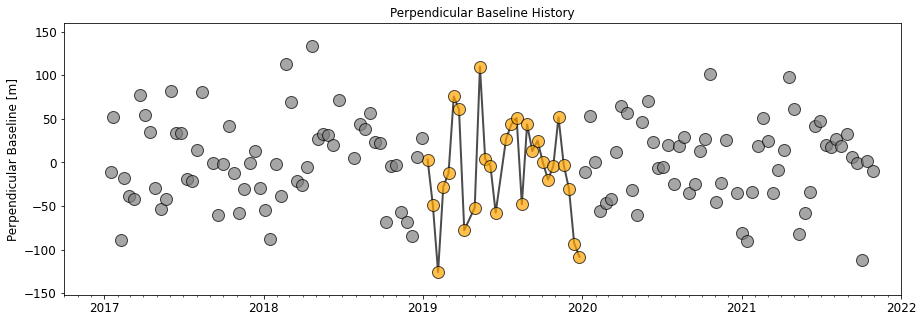

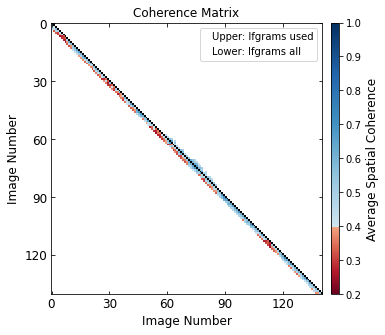

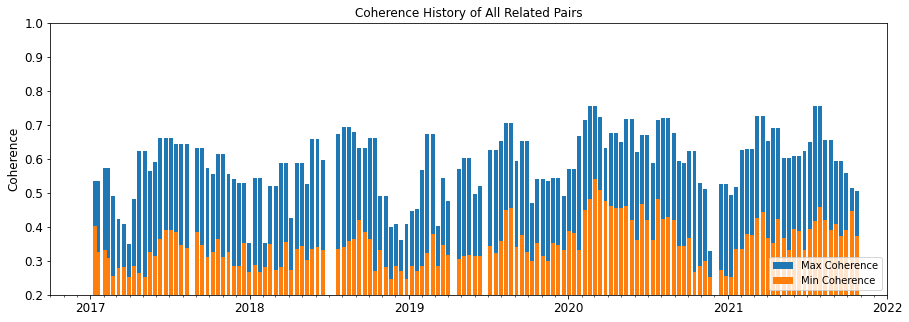

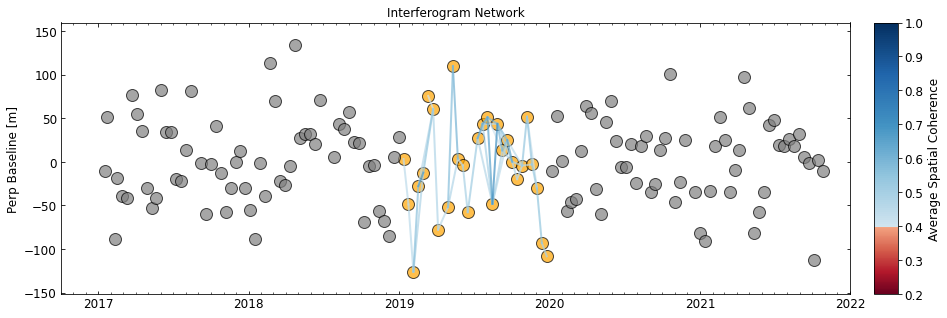

In [6]:
plot_network.main('inputs/ifgramStack.h5 -t hyp3.cfg --show-kept --figsize 15 5'.split())

## view ifgram stack

In [ ]:
d = readfile.read_template('hyp3.cfg')
start_date = datetime.datetime.strptime(d['mintpy.network.startDate'], '%Y%m%d')
end_date = datetime.datetime.strptime(d['mintpy.network.endDate'], '%Y%m%d')
refy, refx = d['mintpy.reference.yx'].split(', ')
min_coh = float(d['mintpy.network.minCoherence'])

used_num = [str(x) for x in m.loc[(m.date1 >= start_date) & (m.date2 <= end_date), 'Num']]

In [ ]:
# view.main(f'inputs/ifgramStack.h5 --noverbose --ref-yx {refy} {refx} -n {" ".join(used_num)}'.split())

In [ ]:
view.main(f'inputs/ifgramStack_2_25.h5 --noverbose --ref-yx {refy} {refx} -n {" ".join(used_num)} --vlim -3 3'.split())

## invert_network
This can take a while so write it to a log if you need to.

In [7]:
# !ifgram_inversion.py inputs/ifgramStack.h5 -t ./hyp3.cfg |& tee -i invert.log ; python ../JPL_internship/emailme.py
!ifgram_inversion.py inputs/ifgramStack.h5 -t ./hyp3.cfg -m waterMask.h5 -o timeseries_asclower_2019.h5 temporalCoherence_asclower_2019.h5 numInvIfgram_asclower_2019.h5

use dataset "unwrapPhase" by default
save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
reference pixel in y/x: (2066, 1589) from dataset: unwrapPhase
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: var
calculate STD: False 
mask: no
-------------------------------------------------------------------------------
number of interferograms: 45
number of acquisitions  : 28
number of lines   : 2394
number of columns : 4120
--------------------------------------------------
create HDF5 file: timeseries_asclower_2019.h5 with w mode
create dataset  : date       of |S8                       in size of (28,)                with compressi

## check timeseries

In [ ]:
view.main('timeseries_asclower_2019.h5 --noverbose'.split())

## check temporal ramp

In [ ]:
ts = timeseries(file='timeseries_asclower_2019.h5')

data = ts.read()
data[data == 0] = np.nan
# data[:,~coh_mask] = np.nan
dates = pd.to_datetime(ts.get_date_list())
means = np.nanmean(data,axis=(1, 2))
means[0] = 0
# datetimes = np.array([datetime.strptime(x,'%Y%m%d').toordinal() for x in dates])

datetimes = np.array([int(x.toordinal()) for x in dates])
slope, intercept, r, p, se = linregress(datetimes,means)
fit = slope*datetimes+intercept
print(f'slope: {round(slope*100,4)} cm\nr2:{round(r**2,2)}')

plt.scatter(datetimes,means)
plt.plot(datetimes,fit,color='red')
plt.ylim(-0.02,0.02)
plt.xlabel('Ordinal Date')
plt.ylabel('Avg Timeseries Value')

## velocity

In [ ]:
%%time
outname = 'velocity_asclower_2019.h5'
!timeseries2velocity.py timeseries_asclower_2019.h5 -o {outname} --bootstrap --bc 100

In [ ]:
view.main(f'{outname} --noverbose -m no --vlim -10 10'.split())

In [ ]:
view.main('temporalCoherence_asclower_2019.h5 --noverbose --colormap RdBu_truncate --cm-vlist 0.0 0.7 1.0'.split())

## Create mask file

In [ ]:
!generate_mask.py temporalCoherence_asclower_2019.h5 -m 0.1 -o maskTempCoh_asclower_2019.h5

In [ ]:
view.main(f'maskTempCoh_asclower_2019.h5 --noverbose'.split())

## Mask velocity file

In [ ]:
maskname = f'{outname.split(".")[0]}_mask.h5'
!mask.py {outname} -m maskTempCoh_asclower_2019.h5 -o {maskname}

In [ ]:
view.main(f'{maskname} --noverbose -m no --vlim -4 4'.split())

## store result files

In [ ]:
ls *h5

In [ ]:
cp *h5 /mnt/i/hyp3_downloads/asc_lower/mintpy

## complete!